In [ ]:
!pip install -q transformers==4.37.2
!pip install bitsandbytes==0.41.3 accelerate==0.25.0
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q gradio
!pip install gTTS

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from transformers import BitsAndBytesConfig, pipeline

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [ ]:
model_id = "llava-hf/llava-1.5-7b-hf"

In [ ]:
pipe = pipeline(
    "image-to-text",
    model=model_id,
    model_kwargs={"quantization_config": quant_config},
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
pipe

In [ ]:
import whisper
import gradio as gr
import time
import os
import warnings
from gtts import gTTS
from PIL import Image

In [ ]:
image_path = "/content/images.jpeg"

In [ ]:
image = Image.open(image_path)

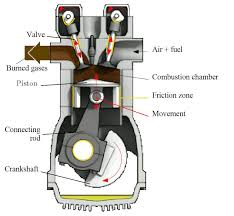

In [ ]:
image

In [ ]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
max_new_tokens = 250

In [ ]:
prompt_instructions = """"
Describe the image using as much detail as possible
You are a helpful AI assistant who is able to answer questions about image with some sense of humour.
What is this image all about?
Now generate the helpful answer.
"""

In [ ]:
prompt = "User: <image> \n" + prompt_instructions + " Assistant:"

In [ ]:
output = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": max_new_tokens})

In [ ]:
output

[{'generated_text': 'User:   \n"\nDescribe the image using as much detail as possible\nYou are a helpful AI assistant who is able to answer questions about image with some sense of humour.\nWhat is this image all about?\nNow generate the helpful answer.\n Assistant: This image is a diagram of a motorcycle engine, showing the various parts and their functions. The engine is described as a "burned gas engine" and is labeled with different parts such as the "fuel tank," "valve," "compressor," and "fission zone." The diagram is labeled with a sense of humor, making it an interesting and informative read for anyone interested in the workings of a motorcycle engine.'}]

In [ ]:
for sent in sent_tokenize(output[0]["generated_text"]):
  print(sent)

User:   
"
Describe the image using as much detail as possible
You are a helpful AI assistant who is able to answer questions about image with some sense of humour.
What is this image all about?
Now generate the helpful answer.
Assistant: This image is a diagram of a motorcycle engine, showing the various parts and their functions.
The engine is described as a "burned gas engine" and is labeled with different parts such as the "fuel tank," "valve," "compressor," and "fission zone."
The diagram is labeled with a sense of humor, making it an interesting and informative read for anyone interested in the workings of a motorcycle engine.


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np

In [ ]:
torch.cuda.is_available()

True

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(f"Using torch:{torch.__version__} ({DEVICE})")

Using torch:2.3.1+cu121 (cuda)


In [ ]:
import whisper

In [ ]:
model = whisper.load_model("medium", device = DEVICE)

100%|██████████████████████████████████████| 1.42G/1.42G [00:13<00:00, 114MiB/s]


In [ ]:
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is multilingual and has 762,321,920 parameters.


In [ ]:
import re
import datetime

In [ ]:
##Logger File
tstamp = datetime.datetime.now()
tstamp = str(tstamp).replace(" ", "_")
logfile = f"log_{tstamp}.txt"

In [ ]:
def writehistory(text):
  with open(logfile, "a",encoding = "utf-8") as f:
    f.write(text)
    f.write("\n")
  f.close()

In [ ]:
import requests

In [ ]:
def img2txt(input_text, input_image):
  image = Image.open(input_image)
  writehistory(f"Input text: {input_text} - Type {type(input_text)} - Dir: {dir(input_text)}")
  if type(input_text) == tuple:
    prompt_instructions = """"
      Describe the image using as much detail as possible
      You are a helpful AI assistant who is able to answer questions about image with some sense of humour.
      What is this image all about?
      Now generate the helpful answer.
      """
  else:
    prompt_instructions = """"
      Describe the image using as much detail as possible
      You are a helpful AI assistant who is able to answer questions about image with some sense of humour.
      What is this image all about?
      and provide a good in depth of the image
      Now generate the helpful answer.
      """

  writehistory(f"prompt instructions: {prompt_instructions}")
  prompt = "User: <image> \n" + prompt_instructions + " Assistant:"

  outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 250})


  if outputs is not None and len(outputs[0]["generated_text"]) > 0:
    match = re.search(r'Assistant:\s*(.*)', outputs[0]["generated_text"])
    if match:
      reply = match.group(1)
    else:
      reply = "No reply found"
  else:
    reply = "No reply found"

  return reply

In [ ]:
def transcribe(audio):

  if audio is None or audio == '':
    return('','',None)

  # For language = 'en'

  audio = whisper.load_audio(audio)
  audio = whisper.pad_or_trim(audio)

  mel = whisper.log_mel_spectrogram(audio).to(model.device)

  _, probs = model.detect_language(mel)

  options = whisper.DecodingOptions()
  result = whisper.decode(model, mel, options)
  result_text = result.text

  return result_text

In [ ]:
def text_to_speech(text,file_path):
  language = 'en'

  audioobj = gTTS(text = text,
                  lang = language,
                  slow = False)

  audioobj.save(file_path)

  return file_path

In [ ]:
import locale

In [ ]:
print(locale.getlocale())

('en_US', 'UTF-8')


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!ffmpeg -f lavfi -i anullsrc=r=44100:cl=mono -t 10 -q:a 9 -acodec libmp3lame Temp.mp3

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
import gradio as gr
import base64
import os

def process_inputs(audio_path,image_path):
  speech_to_text_output = transcribe(audio_path)

  if image_path:
    chatgpt_output = img2txt(speech_to_text_output,image_path)
  else:
    chatgpt_output = "No image provided"

  processed_audio_path = text_to_speech(chatgpt_output, "Temp3.mp3")

  return speech_to_text_output, chatgpt_output, processed_audio_path

# Create interface
iface = gr.Interface(
    fn=process_inputs,
    inputs=[
        gr.Audio(sources=["microphone"], type="filepath"),
        gr.Image(type="filepath")
    ],
    outputs=[
        gr.Textbox(label="Speech to Text"),
        gr.Textbox(label="AI Output"),
        gr.Audio("Temp.mp3")
    ],
    title = "LLM Powered Voice Assistent for the LizMotors Company",
    description = "Upload the image and interact via voice input and audio response ----------------> Made by Kirtan Bhavsar (or Bashira)"
)

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b554d6d83b17399c2a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
